## 1. Import Libraries and MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

## 2. Get data and Pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Create a function to plot the images
def plot_img(i):
    plt.imshow(x_train[i], cmap='binary')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

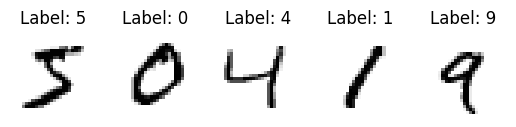

In [4]:
# Plot out the first 5 images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_img(i)

plt.show()

In [5]:
# Normalize the image to [0 - 1] range
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

In [6]:
# View the data shapes
print("Shape before: ", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape before:  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
# Reshape the dimensions of images to (28, 28, 1)
x_train = np.expand_dims(x_train, -1)       # -1 means add a dimensiopn to the end
x_test = np.expand_dims(x_test, -1)


# Purpose: Convert numeric class labels (0–9) into one-hot encoded vectors
# so they match the 10-unit softmax output layer of the neural network.

# Ex:   0: [1,0,0,0,0,0,0,0,0,0]
#       1: [0,1,0,0,0,0,0,0,0,0]
#       5: [0,0,0,0,0,1,0,0,0,0]

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print("Shape after: ", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape after:  (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## 3. Building Model

In [8]:
model = keras.Sequential([
    # Conv2D layer: 32 filters, 3x3 kernel, input 28x28x1, ReLU activation
    Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
    # MaxPool2D layer: 2x2 pooling, downsamples feature map, keeps strongest features
    MaxPool2D((2, 2)),

    # A model only need 1 input_shape attribute above
    # Increase number filters to 64 to learn more complex patterns
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),

    # Cnvert the 2D / 3D feature map to 1D
    Flatten(),
    
    # Dropout: randomly drop 25% neurons to reduce overfitting
    Dropout(0.25),

    # Output Dense layer: 10 neurons for 10 classes, softmax activation for probabilities
    Dense(10, activation='softmax')
])

model.summary()

c:\Users\vppho\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [10]:
# Import Callbacks to prevent Overfitting
from keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping - stop if validation accuracy stop improving
es = EarlyStopping(
    monitor='val_accuracy',         # tracks validation accuracy
    mode='max',                     # Look for higher accuracy
    min_delta=0.01,                 # minimum improvement required
    patience=4,                     # Stop after 4 epochs with no improvement
    verbose=1                       # Print out message if stopped
)

# ModelCheckpoint - save only the best model based on accuracy
mc = ModelCheckpoint(
    "./bestmodel.keras",           # Path to save model
    monitor='val_accuracy',        # Metric to decide the best model
    mode='max',
    verbose=1,                     # Print out message when save the model
    save_best_only=True            # Save only when perfomance improves
)

# Combine callbacks
cb = [es, mc]

## 4. Model training

In [11]:
# Train model for 50 epochs, using 30% of training data for validation
his = model.fit(x_train, y_train, epochs=50, validation_split=0.3, callbacks=cb)

Epoch 1/50
1305/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8583 - loss: 0.4674
Epoch 1: val_accuracy improved from None to 0.97517, saving model to ./bestmodel.keras

Epoch 1: finished saving model to ./bestmodel.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9357 - loss: 0.2136 - val_accuracy: 0.9752 - val_loss: 0.0817
Epoch 2/50
1310/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9729 - loss: 0.0815
Epoch 2: val_accuracy improved from 0.97517 to 0.98033, saving model to ./bestmodel.keras

Epoch 2: finished saving model to ./bestmodel.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9756 - loss: 0.0755 - val_accuracy: 0.9803 - val_loss: 0.0654
Epoch 3/50
1307/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9824 - loss: 0.0563
Epoch 3: val_accuracy improved from 0.98033 to 0.98467, saving model to ./bestmodel.keras

Epoch 3: finished saving model to ./bestmodel.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9830 - loss: 0.

In [13]:
# Load the model from .keras file
model_keras = keras.models.load_model('D:\\Machine_Learning-Deep_Learning\\Handwritten Number Regconition\\bestmodel.keras')
model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,480 (408.13 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,654 (272.09 KB)

## 5. Model evaluation

In [14]:
# Get the performance on test set
performance = model_keras.evaluate(x_test, y_test)

# performance = [loss, accuracy]
print('The model accuracy is: ', performance[1])
print('The model loss is: ', performance[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9887 - loss: 0.0346
The model accuracy is:  0.9886999726295471
The model loss is:  0.03459387645125389
